In [19]:
import tensorflow as tf
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

%run utils.ipynb

# GPU setup

In [20]:
gpu_setup()

Detected GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Data preprocessing


## Indicate the path of the dataset

In [21]:
data_dir = pathlib.Path('./Faces').with_suffix('')

## Split the data into Train and Validation sets

In [22]:
# Introduce the Batch size and Image size
BATCH_SIZE = 32
IMG_HEIGHT = 160
IMG_WIDTH = 160
CHANNELS = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

In [23]:
# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2562 files belonging to 31 classes.
Using 2050 files for training.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2562 files belonging to 31 classes.
Using 512 files for validation.


## Check the labels and get number of classes

In [25]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(class_names)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


## Examine some of the training images

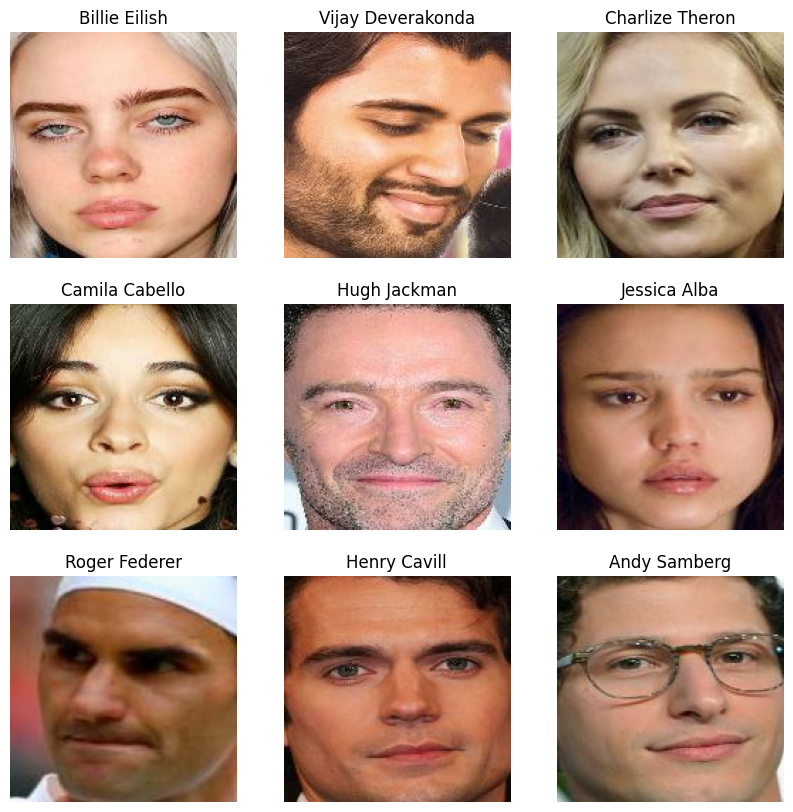

In [26]:
plot_images(train_ds, class_names, 3, 3)

## Examine each batch in training dataset

In [27]:
batch_examination(train_ds)

Each batch image shape: (32, 160, 160, 3)
Each batch label shape: (32,)


## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Data augmentation

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=IMG_SHAPE),
    layers.RandomRotation(0.1),  # Increase rotation angle
    layers.RandomZoom(0.1),      # Increase zoom factor
    layers.RandomContrast(0.1),  # Add contrast adjustment
    layers.RandomBrightness([-0.2, 0.2]),
  ]
)

### Visualize all augmentations on one image

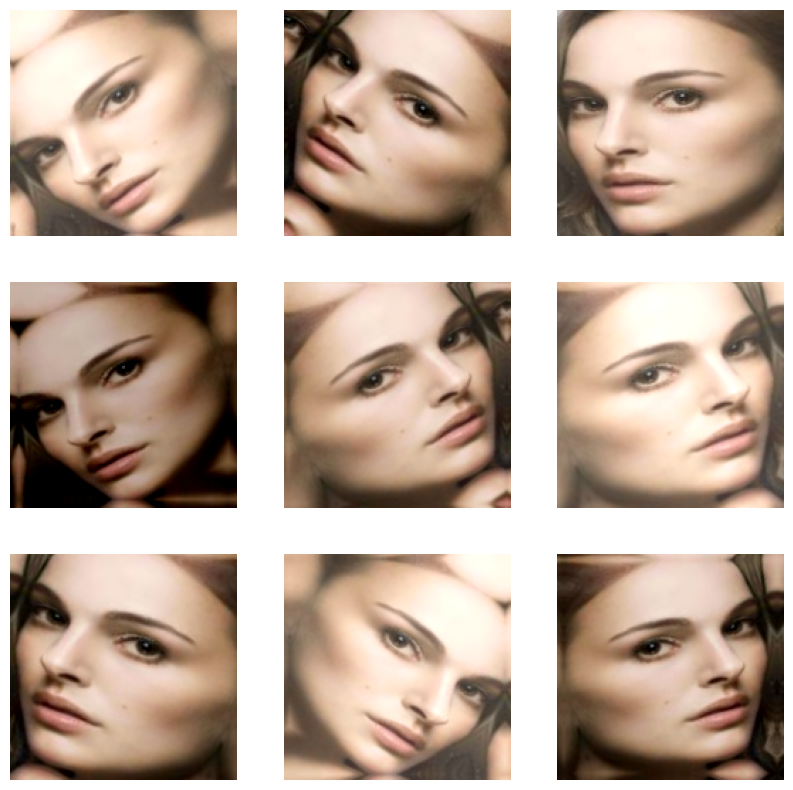

In [30]:
plot_augmentations(train_ds, data_augmentation, 3, 3)

### Visualize augmentations on different images

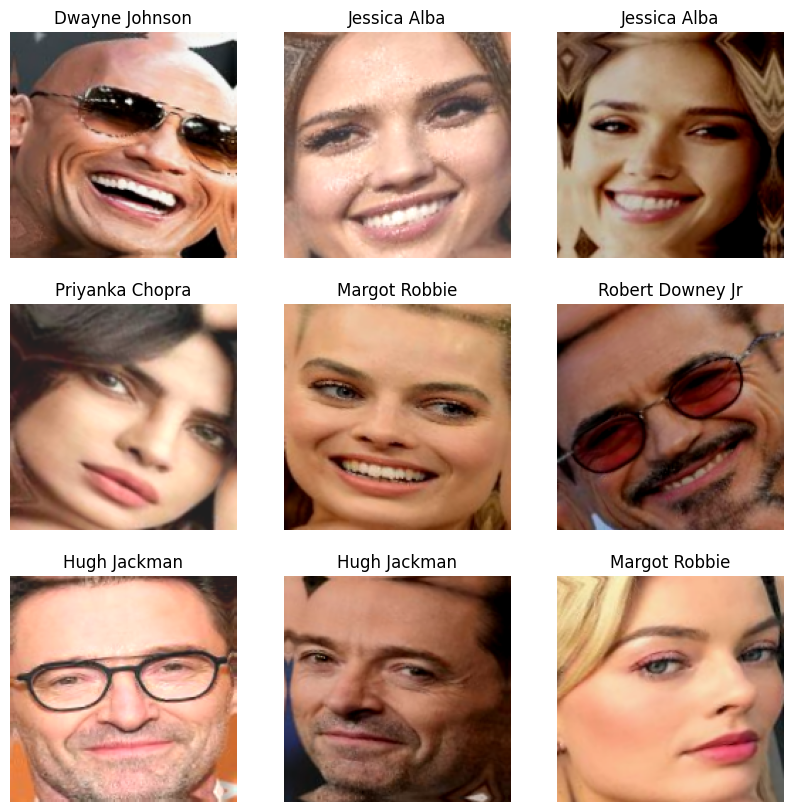

In [31]:
plot_images(train_ds, class_names, 3, 3, data_augmentation)

# Building and Training the model

## Build the model architecture

Here we build a custom model for our better dataset so afterwards we can use it for transfer learning on our primary dataset.

In [32]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(NUM_CLASSES, name="outputs")
])

In [33]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 80, 80, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 40, 40, 32)        0         
 g2D)                                                 

## Train the model

In [35]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


65/65 [==============================] - 3s 20ms/step - loss: 4.1087 - accuracy: 0.0424 - val_loss: 3.4718 - val_accuracy: 0.0371
Epoch 2/100
65/65 [==============================] - 1s 19ms/step - loss: 3.4369 - accuracy: 0.0420 - val_loss: 3.4186 - val_accuracy: 0.0547
Epoch 3/100
65/65 [==============================] - 2s 25ms/step - loss: 3.3973 - accuracy: 0.0644 - val_loss: 3.3063 - val_accuracy: 0.1191
Epoch 4/100
65/65 [==============================] - 5s 74ms/step - loss: 3.2173 - accuracy: 0.1278 - val_loss: 3.0312 - val_accuracy: 0.1367
Epoch 5/100
65/65 [==============================] - 5s 73ms/step - loss: 3.0266 - accuracy: 0.1444 - val_loss: 2.7918 - val_accuracy: 0.2012
Epoch 6/100
65/65 [==============================] - 5s 73ms/step - loss: 2.9019 - accuracy: 0.1810 - val_loss: 2.7600 - val_accuracy: 0.2031
Epoch 7/100
65/65 [==============================] - 5s 73ms/step - loss: 2.7728 - accuracy: 0.2054 - val_loss: 2.6062 - val_accuracy: 0.2715
Epoch 8/100
65/65 

## Plot the results

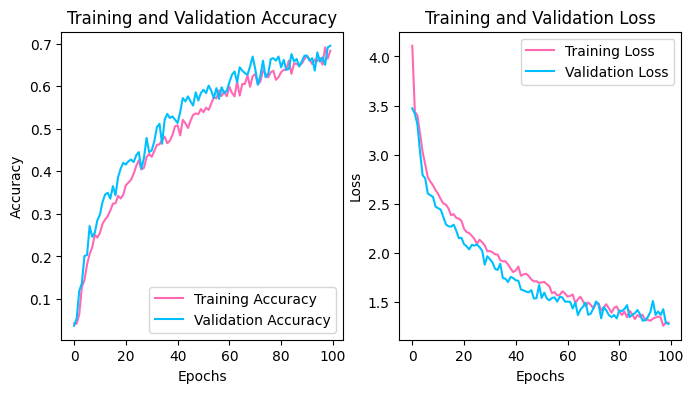

In [36]:
plot_loss_accuracy(history, epochs)

# Save the trained model

In [38]:
model.save('face_recognition.keras')